간단한 머신러닝
- 인코딩, 정규화
- randomforest
- 가능하다면, cnn, lstm 적용

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


import matplotlib as plt

In [7]:
tdf = pd.DataFrame(pd.read_csv('./total_thermal_noAC.csv', index_col=0, header=0))

tdf = tdf.drop(columns=['timestamp', 'etc_1', 'etc_2'])
print(tdf.shape)
tdf.head()

(10002, 66)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4392\2458045072.py:1: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  tdf = pd.DataFrame(pd.read_csv('./total_thermal_noAC.csv', index_col=0, header=0))


,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,thermal_08,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,status
True,,,,,,,,,,,,,,,,,,,,,
0,29.9375,25.75,25.25,25.25,25.75,25.75,24.50,24.75,24.75,25.25,...,23.50,24.50,50.75,42.50,25.25,24.75,25.75,23.25,22.50,heater
1,29.9375,25.00,24.75,24.75,25.50,25.00,25.00,24.75,26.25,25.50,...,23.50,25.25,51.00,42.50,24.50,26.00,25.00,23.00,22.50,heater
2,29.9375,25.25,25.25,25.50,25.75,25.75,25.50,25.75,26.25,25.00,...,23.25,24.75,51.25,42.75,25.00,25.75,25.00,23.00,22.25,heater
3,30.0000,26.00,25.75,25.25,26.00,25.50,25.25,25.75,25.50,25.50,...,23.75,24.75,50.75,42.50,25.00,25.75,25.25,23.25,22.75,heater
4,29.9375,26.25,25.75,25.50,26.00,25.00,25.50,25.75,26.00,25.75,...,23.50,24.75,50.25,42.75,25.25,26.00,25.50,23.00,22.25,heater


In [8]:
tdf.insert(65, 'avg', 0, allow_duplicates=False )
for x in range(len(tdf.index)):
    tdf.iloc[x, 65] = round(tdf.iloc[x,1:65].mean(),2)
tdf = tdf.loc[tdf['status']!='heater', :]
tdf.head()
tdf.shape


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4392\3683875019.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.iloc[x, 65] = round(tdf.iloc[x,1:65].mean(),2)


(8096, 67)

In [9]:
tdf['status'].unique()

array(['human1', 'human2', nan], dtype=object)

In [10]:
tdf['status'] = tdf['status'].str.replace('1', '')
tdf['status'] = tdf['status'].str.replace('2', '')
tdf['status'].unique()

array(['human', nan], dtype=object)

In [11]:
tdf8 = tdf.iloc[:,1:-2]

In [12]:
import numpy as np
from scipy.ndimage import gaussian_filter, zoom
import matplotlib.pyplot as plt

def process_data_to_image(data_64_columns, sigma=1.0, output_shape=(24, 24), plot_results=True):
    """
    64개의 컬럼 데이터를 8x8 배열로 변환하고, 가우시안 필터를 적용한 후
    지정된 크기(기본 24x24)로 확대하는 함수.

    Args:
        data_64_columns (np.ndarray): 64개의 원소를 가진 1차원 NumPy 배열.
                                      (예: np.random.rand(64) 또는 실제 데이터)
        sigma (float): 가우시안 필터의 표준 편차. 값이 클수록 더 많이 흐려집니다.
        output_shape (tuple): 최종 확대될 배열의 크기 (높이, 너비).
        plot_results (bool): 중간 과정 및 최종 결과를 시각화할지 여부.

    Returns:
        np.ndarray: 가우시안 필터링 및 확대가 완료된 2D NumPy 배열 (output_shape 크기).
    """

    # 1. 64개의 컬럼 데이터를 8x8 배열로 변환
    if data_64_columns.shape[0] != 64:
        raise ValueError("입력 데이터는 정확히 64개의 원소를 가져야 합니다.")
    
    # 8x8로 reshape (행 우선)
    # 데이터를 어떻게 8x8로 배열할지는 데이터의 의미에 따라 달라질 수 있습니다.
    # 여기서는 첫 8개가 첫 행, 다음 8개가 다음 행... 이런 식으로 가정합니다.
    array_8x8 = data_64_columns.reshape((8, 8))
    print(f"원본 8x8 배열:\n{array_8x8}\n")

    # 2. 8x8 배열에 가우시안 필터 적용
    # sigma 값은 블러의 강도를 조절합니다.
    filtered_8x8 = gaussian_filter(array_8x8, sigma=sigma)
    print(f"가우시안 필터 적용 후 8x8 배열 (sigma={sigma}):\n{filtered_8x8}\n")

    # 3. 24x24 크기 배열로 확대 (보간)
    # zoom 함수를 사용하여 스케일링 비율을 계산합니다.
    # 예: 24/8 = 3.0 이므로 3배 확대
    zoom_factor_h = output_shape[0] / array_8x8.shape[0]
    zoom_factor_w = output_shape[1] / array_8x8.shape[1]
    
    # zoom 함수는 각 차원에 대한 확대 비율을 인자로 받습니다.
    # order=3은 쌍삼차 보간(bicubic interpolation)을 의미하며,
    # 이는 일반적으로 양선형 보간(bilinear)보다 부드러운 결과를 제공합니다.
    final_24x24_array = zoom(filtered_8x8, zoom=(zoom_factor_h, zoom_factor_w), order=3)
    print(f"최종 {output_shape[0]}x{output_shape[1]} 배열:\n{final_24x24_array}\n")

    # 결과 시각화
    if plot_results:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # 원본 8x8
        im1 = axes[0].imshow(array_8x8, cmap='viridis', interpolation='nearest') # 'nearest'로 픽셀을 명확히
        axes[0].set_title('1. Original 8x8 Array')
        fig.colorbar(im1, ax=axes[0])

        # 필터링된 8x8
        im2 = axes[1].imshow(filtered_8x8, cmap='viridis', interpolation='nearest') # 'nearest'로 픽셀을 명확히
        axes[1].set_title(f'2. Gaussian Filtered 8x8 (sigma={sigma})')
        fig.colorbar(im2, ax=axes[1])

        # 최종 24x24
        im3 = axes[2].imshow(final_24x24_array, cmap='viridis', interpolation='bicubic') # 'bicubic'으로 부드럽게
        axes[2].set_title(f'3. Final {output_shape[0]}x{output_shape[1]} Array (Upscaled)')
        fig.colorbar(im3, ax=axes[2])

        plt.tight_layout()
        plt.show()

    return final_24x24_array


In [21]:
def process_data_to_image2(data_64_columns, sigma=1.0, output_shape=(24, 24), plot_results=True):
    """
    64개의 컬럼 데이터를 8x8 배열로 변환하고, 가우시안 필터를 적용한 후
    지정된 크기(기본 24x24)로 확대하는 함수.

    Args:
        data_64_columns (np.ndarray): 64개의 원소를 가진 1차원 NumPy 배열.
                                      (예: np.random.rand(64) 또는 실제 데이터)
        sigma (float): 가우시안 필터의 표준 편차. 값이 클수록 더 많이 흐려집니다.
        output_shape (tuple): 최종 확대될 배열의 크기 (높이, 너비).
        plot_results (bool): 중간 과정 및 최종 결과를 시각화할지 여부.

    Returns:
        np.ndarray: 가우시안 필터링 및 확대가 완료된 2D NumPy 배열 (output_shape 크기).
    """

    # 1. 64개의 컬럼 데이터를 8x8 배열로 변환
    if data_64_columns.shape[0] != 64:
        raise ValueError("입력 데이터는 정확히 64개의 원소를 가져야 합니다.")
    
    # 8x8로 reshape (행 우선)
    # 데이터를 어떻게 8x8로 배열할지는 데이터의 의미에 따라 달라질 수 있습니다.
    # 여기서는 첫 8개가 첫 행, 다음 8개가 다음 행... 이런 식으로 가정합니다.
    array_8x8 = data_64_columns.reshape((8, 8))
    # print(f"원본 8x8 배열:\n{array_8x8}\n")
    
    # 2. 24x24 크기 배열로 확대 (보간)
    # zoom 함수를 사용하여 스케일링 비율을 계산합니다.
    # 예: 24/8 = 3.0 이므로 3배 확대
    zoom_factor_h = output_shape[0] / array_8x8.shape[0]
    zoom_factor_w = output_shape[1] / array_8x8.shape[1]
    
    # zoom 함수는 각 차원에 대한 확대 비율을 인자로 받습니다.
    # order=3은 쌍삼차 보간(bicubic interpolation)을 의미하며,
    # 이는 일반적으로 양선형 보간(bilinear)보다 부드러운 결과를 제공합니다.
    array_24x24 = zoom(array_8x8, zoom=(zoom_factor_h, zoom_factor_w), order=3)
    # print(f"2424로 확대 배열 (sigma={sigma}):\n{array_24x24}\n")
    
    # 3. 24x24 배열에 가우시안 필터 적용
    # sigma 값은 블러의 강도를 조절합니다.
    filtered_24x24 = gaussian_filter(array_24x24, sigma=sigma)
    # print(f"최종 {output_shape[0]}x{output_shape[1]} 배열:\n{filtered_24x24}\n")

    # 결과 시각화
    if plot_results:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # 원본 8x8
        im1 = axes[0].imshow(array_8x8, cmap='viridis', interpolation='nearest') # 'nearest'로 픽셀을 명확히
        axes[0].set_title('1. Original 8x8 Array')
        fig.colorbar(im1, ax=axes[0])

        # 필터링된 8x8
        im2 = axes[1].imshow(array_24x24, cmap='viridis', interpolation='nearest') # 'nearest'로 픽셀을 명확히
        axes[1].set_title(f'2. expanded 24x24 ')
        fig.colorbar(im2, ax=axes[1])

        # 최종 24x24
        im3 = axes[2].imshow(filtered_24x24, cmap='viridis', interpolation='bicubic') # 'bicubic'으로 부드럽게
        axes[2].set_title(f'3. Final {output_shape[0]}x{output_shape[1]} Array (sigma={sigma})')
        fig.colorbar(im3, ax=axes[2])

        plt.tight_layout()
        plt.show()

    return filtered_24x24


In [22]:
aray8 = tdf8.iloc[0,:].values.reshape(8,8)
aray8.shape

(8, 8)

원본 8x8 배열:
[[24.   24.75 25.   25.25 24.5  24.75 24.5  25.  ]
 [25.75 24.25 24.75 25.   24.5  24.   24.5  23.5 ]
 [25.5  25.   24.25 24.   23.5  23.75 23.5  23.75]
 [25.   24.   24.25 24.   24.   23.75 23.75 24.25]
 [24.5  24.25 23.75 24.25 24.   24.25 23.5  24.  ]
 [24.25 25.   24.   24.5  24.25 24.   23.75 24.  ]
 [24.75 24.25 24.   24.25 23.75 24.25 23.5  23.5 ]
 [25.25 24.5  25.25 24.75 25.25 25.   23.75 23.  ]]

가우시안 필터 적용 후 8x8 배열 (sigma=0.8):
[[24.52178947 24.66831434 24.88867325 24.92311819 24.65703151 24.52616492
  24.52162413 24.56527934]
 [25.051097   24.75449857 24.68490225 24.63650771 24.36474194 24.19705541
  24.14909233 24.02964288]
 [25.16140243 24.72587362 24.40452016 24.19648695 23.96568213 23.85064082
  23.8251942  23.83242155]
 [24.8081637  24.44067302 24.18292596 24.05964008 23.9392967  23.83974414
  23.81032093 23.95156203]
 [24.51953792 24.32788708 24.12635578 24.12760807 24.08254054 23.96165146
  23.83424601 23.93419799]
 [24.4907181  24.4299131  24.23008068 24.

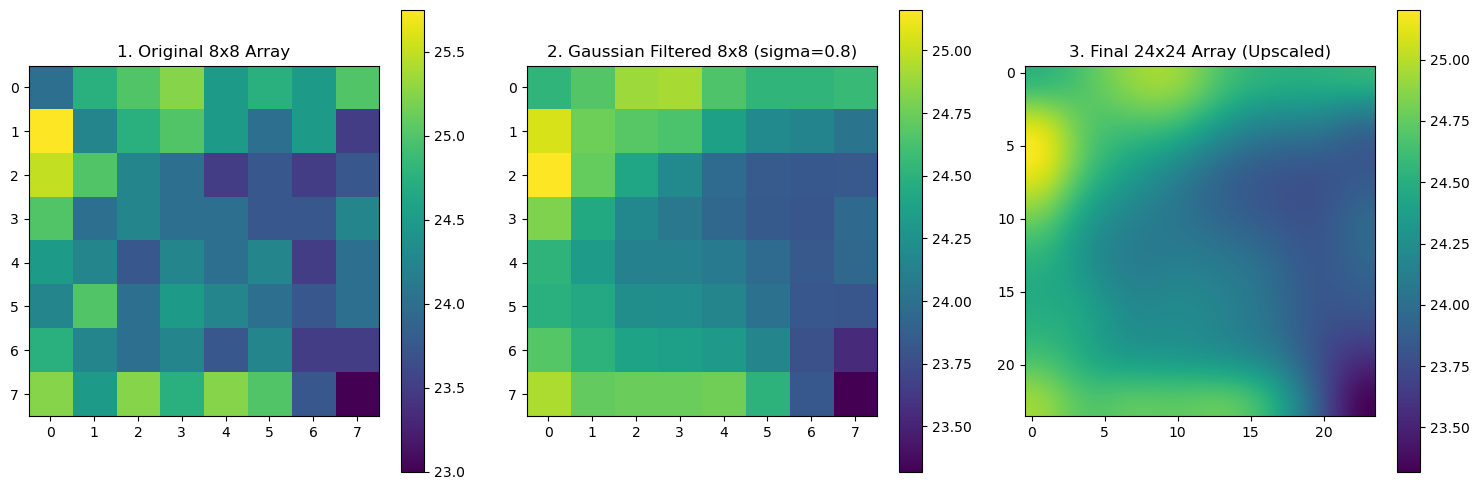


최종 처리된 배열의 shape: (24, 24)


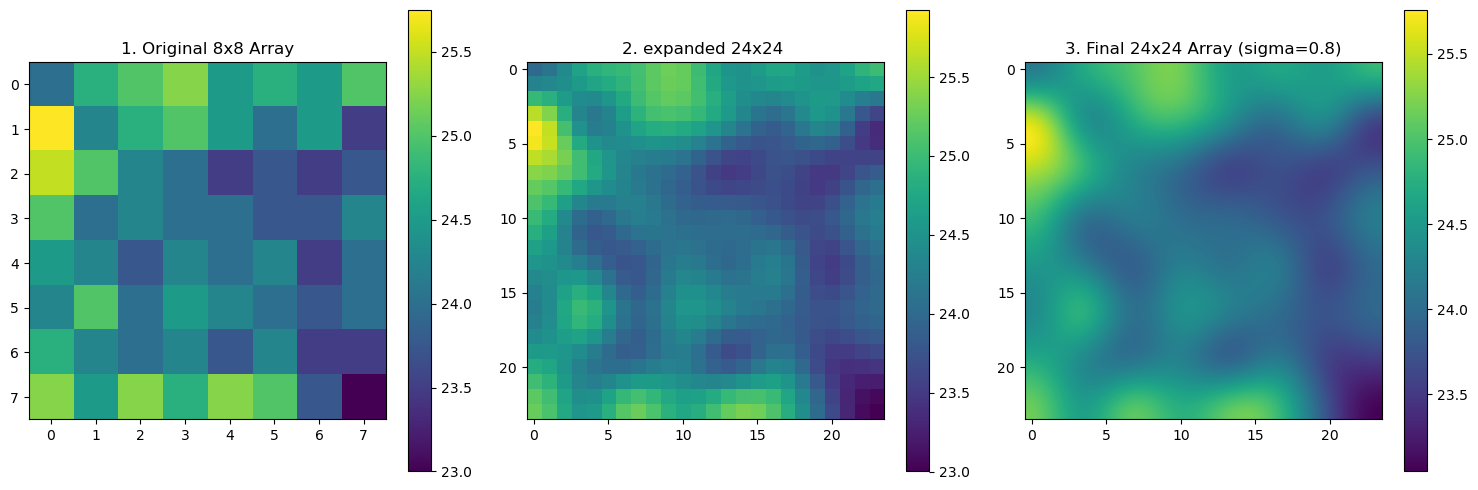


최종 처리된 배열의 shape: (24, 24)


In [23]:

result_array = process_data_to_image(tdf8.iloc[0,:].values, sigma=0.8, output_shape=(24, 24))
print("\n최종 처리된 배열의 shape:", result_array.shape)
result_array2 = process_data_to_image2(tdf8.iloc[0,:].values, sigma=0.8, output_shape=(24, 24))
print("\n최종 처리된 배열의 shape:", result_array.shape)

In [17]:
# 2424 배열에 평균 추가
# 해당데이터로 rf, lgbm 학습시도
# 점수확인

In [20]:
fdf = pd.DataFrame(pd.read_csv('./24f_hn_thermal.csv', index_col=0))
fdf.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4392\3635545749.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  fdf = pd.DataFrame(pd.read_csv('./24f_hn_thermal.csv', index_col=0))


,status,mean,processed_pixel_0,processed_pixel_1,processed_pixel_2,processed_pixel_3,processed_pixel_4,processed_pixel_5,processed_pixel_6,processed_pixel_7,...,processed_pixel_566,processed_pixel_567,processed_pixel_568,processed_pixel_569,processed_pixel_570,processed_pixel_571,processed_pixel_572,processed_pixel_573,processed_pixel_574,processed_pixel_575
0,human,24.26,24.129915,24.232569,24.423254,24.631378,24.785988,24.879602,24.955297,25.054200,...,25.198042,25.172457,25.025170,24.761140,24.409388,24.020410,23.649618,23.344608,23.140255,23.047730
1,human,24.17,24.753899,24.710367,24.622850,24.510983,24.402313,24.318436,24.274923,24.281239,...,25.587303,25.892480,25.874561,25.381683,24.525702,23.656712,23.132540,23.064388,23.246809,23.401922
2,human,24.14,24.144985,24.254488,24.446781,24.628902,24.717434,24.724920,24.738949,24.838488,...,24.512398,24.542742,24.512537,24.361790,24.094885,23.775682,23.480370,23.259266,23.126299,23.071007
3,human,24.07,24.778610,24.724268,24.619476,24.495794,24.390410,24.321150,24.289526,24.293243,...,24.649242,24.809520,24.890520,24.811165,24.573503,24.256147,23.953684,23.727694,23.593620,23.538603
4,human,24.02,24.278418,24.279010,24.271225,24.240593,24.181036,24.110420,24.064430,24.072409,...,24.595901,24.710165,24.734507,24.596498,24.314228,23.988600,23.730898,23.593086,23.548843,23.544188


In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [26]:
l_ecd = LabelEncoder()
fdf['status'] = l_ecd.fit_transform(fdf['status'])
fdf['status'].unique()

array([0, 1])

In [27]:
fdf.iloc[:,1:]

,mean,processed_pixel_0,processed_pixel_1,processed_pixel_2,processed_pixel_3,processed_pixel_4,processed_pixel_5,processed_pixel_6,processed_pixel_7,processed_pixel_8,...,processed_pixel_566,processed_pixel_567,processed_pixel_568,processed_pixel_569,processed_pixel_570,processed_pixel_571,processed_pixel_572,processed_pixel_573,processed_pixel_574,processed_pixel_575
0,24.26,24.129915,24.232569,24.423254,24.631378,24.785988,24.879602,24.955297,25.054200,25.167475,...,25.198042,25.172457,25.025170,24.761140,24.409388,24.020410,23.649618,23.344608,23.140255,23.047730
1,24.17,24.753899,24.710367,24.622850,24.510983,24.402313,24.318436,24.274923,24.281239,24.333810,...,25.587303,25.892480,25.874561,25.381683,24.525702,23.656712,23.132540,23.064388,23.246809,23.401922
2,24.14,24.144985,24.254488,24.446781,24.628902,24.717434,24.724920,24.738949,24.838488,25.011230,...,24.512398,24.542742,24.512537,24.361790,24.094885,23.775682,23.480370,23.259266,23.126299,23.071007
3,24.07,24.778610,24.724268,24.619476,24.495794,24.390410,24.321150,24.289526,24.293243,24.332830,...,24.649242,24.809520,24.890520,24.811165,24.573503,24.256147,23.953684,23.727694,23.593620,23.538603
4,24.02,24.278418,24.279010,24.271225,24.240593,24.181036,24.110420,24.064430,24.072409,24.129198,...,24.595901,24.710165,24.734507,24.596498,24.314228,23.988600,23.730898,23.593086,23.548843,23.544188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091,24.07,24.320969,24.323050,24.350500,24.440132,24.612797,24.842104,25.065317,25.221155,25.284422,...,24.715393,24.677856,24.548555,24.344002,24.075724,23.750820,23.383686,23.018812,22.735594,22.595081
8092,23.91,24.237972,24.110107,23.929605,23.876638,24.091827,24.516245,24.935410,25.142950,25.092438,...,24.043596,24.306470,24.369274,24.040230,23.391090,22.733196,22.390032,22.452044,22.710617,22.896738
8093,23.96,24.781933,24.833960,24.906897,24.927040,24.840033,24.680235,24.550495,24.544912,24.671669,...,24.072002,24.414667,24.592318,24.405685,23.884916,23.270239,22.826610,22.662931,22.683851,22.735080
8094,23.82,24.337757,24.369364,24.420738,24.458797,24.459059,24.440018,24.452549,24.535198,24.661394,...,24.109362,24.236368,24.217539,23.964570,23.501394,22.954762,22.468744,22.128944,21.941370,21.869328


In [28]:
rscaler = MinMaxScaler()
fdf.iloc[:,1:] = rscaler.fit_transform(fdf.iloc[:,1:])
fdf.head()

,status,mean,processed_pixel_0,processed_pixel_1,processed_pixel_2,processed_pixel_3,processed_pixel_4,processed_pixel_5,processed_pixel_6,processed_pixel_7,...,processed_pixel_566,processed_pixel_567,processed_pixel_568,processed_pixel_569,processed_pixel_570,processed_pixel_571,processed_pixel_572,processed_pixel_573,processed_pixel_574,processed_pixel_575
0,0,0.492593,0.271646,0.307845,0.357554,0.384463,0.407595,0.461612,0.492444,0.472269,...,0.360866,0.353212,0.361252,0.366936,0.381534,0.355767,0.341420,0.352051,0.371314,0.375122
1,0,0.459259,0.401696,0.414678,0.404756,0.357967,0.323548,0.332214,0.324830,0.281245,...,0.433168,0.484383,0.518773,0.483302,0.404426,0.291540,0.255136,0.303765,0.388723,0.430647
2,0,0.448148,0.274787,0.312746,0.363118,0.383918,0.392577,0.425944,0.439146,0.418959,...,0.233514,0.238494,0.266183,0.292049,0.319635,0.312550,0.313178,0.337345,0.369034,0.378771
3,0,0.422222,0.406847,0.417786,0.403958,0.354624,0.320941,0.332840,0.328427,0.284212,...,0.258931,0.287094,0.336281,0.376317,0.413834,0.397397,0.392160,0.418062,0.445384,0.452074
4,0,0.403704,0.302597,0.318229,0.321601,0.298462,0.275076,0.284248,0.272974,0.229637,...,0.249024,0.268994,0.307348,0.336062,0.362805,0.350150,0.354984,0.394867,0.438069,0.452950


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.discovery import *
from sklearn.metrics import *
import warnings
rets=all_estimators(type_filter='classifier')

In [32]:
train_data = fdf.iloc[:,1:]
print(train_data.head())
train_label = fdf.iloc[:,0]
print(train_label.head())

       mean  processed_pixel_0  processed_pixel_1  processed_pixel_2  \
0  0.492593           0.271646           0.307845           0.357554   
1  0.459259           0.401696           0.414678           0.404756   
2  0.448148           0.274787           0.312746           0.363118   
3  0.422222           0.406847           0.417786           0.403958   
4  0.403704           0.302597           0.318229           0.321601   

   processed_pixel_3  processed_pixel_4  processed_pixel_5  processed_pixel_6  \
0           0.384463           0.407595           0.461612           0.492444   
1           0.357967           0.323548           0.332214           0.324830   
2           0.383918           0.392577           0.425944           0.439146   
3           0.354624           0.320941           0.332840           0.328427   
4           0.298462           0.275076           0.284248           0.272974   

   processed_pixel_7  processed_pixel_8  ...  processed_pixel_566  \
0          

In [ ]:
## find estimator
result=[]
for name, estimator_ in rets:
    try:
        model=estimator_()
        if 'Logistic' in name or 'SGD' in name or 'MLP' in name:
            model.set_params(max_iter=10000)
        if 'SV' in name:
            model.set_params(max_iter=100000, dual='auto')   
 
        model.fit(train_data, train_label)
        sc=model.score(train_data, train_label)
        result.append((name, round(sc, 2)))
    except Exception:
        pass

In [148]:
# sorted(result, key=lambda x : x[1], reverse=True)
X_train, X_test, y_train, y_test =train_test_split(train_data,train_label)

In [149]:
def train_result(model):
    
    name = (str(model.__class__)).split('.')[3]
    # 학습
    model.fit(X_train, y_train)
    
    # 훈련 데이터와 테스트 데이터에서 정확도 계산
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # 예측값 계산
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 정확도 차이 계산
    diff = train_score - test_score
    
    # 평가 지표
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # F1-Score 등 더 상세한 평가 지표
    train_classification_report = classification_report(y_train, y_train_pred)
    test_classification_report = classification_report(y_test, y_test_pred)
    
    # 혼동 행렬
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    
    # 결과 데이터프레임 준비
    resultDF = pd.DataFrame(columns=['train_score', 'test_score', 'diff', 
                                    'train_accuracy', 'test_accuracy'] )
                                    # 'train_classification_report', 'test_classification_report',
                                    # 'train_confusion_matrix', 'test_confusion_matrix'])
    resultDF.loc[name] = [train_score, test_score, diff, 
                            train_accuracy, test_accuracy]
    print('train_classification_report')
    print(train_classification_report)
    print('test_classification_report')
    print(test_classification_report)
    print('train_confusion_matrix')
    print(train_confusion_matrix)
    print('test_confusion_matrix')
    print(test_confusion_matrix)
    
    return model, resultDF

In [150]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
def gridCV_(model, param):
    ## 교차검증 및 튜닝 진행 인스턴스 생성
    # GridSearchCV는 모든 파라미터 조합을 시도합니다.
    # cv: 교차 검증 폴드 수 (일반적으로 3, 5, 10 등)
    # n_jobs: 병렬 처리할 작업 수 (-1은 모든 코어 사용)
    # verbose: 진행 상황 출력 레벨 (0: 출력 안 함, 1: 간략하게, 2: 상세하게)
    # error_score: 에러 발생 시 처리 방법 ('raise' 또는 특정 숫자)
    gridCV = GridSearchCV(model, param, refit=True, cv=5, n_jobs=-1, verbose=2, error_score='raise')
    print("구성된 하이퍼파라미터 탐색 범위:")
    for key, value in param.items():
        print(f"- {key}: {value}")
        
    gridCV.fit(X_train, y_train) # 학습 데이터로 최적의 파라미터를 찾습니다.
    print("--- GridSearchCV 모델 학습 완료 ---")
    print("-" * 30)

    # 4. 최적의 하이퍼파라미터 및 최고 성능 확인
    # -----------------------------------------------------------------------------
    print("\n--- 최적의 하이퍼파라미터 조합 ---")
    best_params = gridCV.best_params_
    print(best_params)

    print("\n--- 최적 모델의 교차 검증 최고 점수 ---")
    best_score = gridCV.best_score_
    print(f"정확도: {best_score:.4f}")
    print("-" * 30)

    # 5. 최적의 모델로 예측 및 성능 평가
    # -----------------------------------------------------------------------------
    # gridCV.best_estimator_에 refit=True 옵션 덕분에 최적의 파라미터로 학습된 모델이 저장됩니다.
    best_model = gridCV.best_estimator_

    print("\n--- 최적 모델로 테스트 데이터 예측 및 평가 ---")
    y_pred_test = best_model.predict(X_test)

    # 정확도
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"테스트 세트 정확도: {test_accuracy:.4f}")

    # 혼동 행렬
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    print("\n테스트 세트 혼동 행렬:")
    print(test_confusion_matrix)

    # 분류 보고서 (정밀도, 재현율, F1-스코어 등)
    test_classification_report = classification_report(y_test, y_pred_test)
    print("\n테스트 세트 분류 보고서:")
    print(test_classification_report)
    print("-" * 30)

    # 6. 결과 데이터프레임에 저장 (이전 질문의 코드 재활용)
    # -----------------------------------------------------------------------------
    # resultDF 초기화 (없을 경우 새로 생성)
    try:
        if not isinstance(resultDF, pd.DataFrame):
            raise NameError # DataFrame이 아니면 NameError 발생시켜 새로 생성
    except NameError:
        resultDF = pd.DataFrame(columns=['train_score', 'test_score', 'diff',
                                        'train_accuracy', 'test_accuracy',
                                        'train_classification_report', 'test_classification_report',
                                        'train_confusion_matrix', 'best_params']) # confusion_matrix는 dict 타입이 아니므로 주의
                                                                                # 여기서는 best_params를 추가함

    name = f"{str(model.__class__).split('.')[3]}_GridSearch_Best_{best_score:.4f}" # 모델 이름에 최고 점수 포함

    # GridSearchCV 결과에서 train_score는 gridCV.best_score_ (교차 검증 평균)가 됩니다.
    train_score_cv = gridCV.best_score_
    train_accuracy_cv = best_model.score(X_train, y_train) # 훈련 세트에서의 최종 모델 정확도

    diff = train_score_cv - test_accuracy

    # confusion matrix는 DataFrame에 직접 넣기보다 문자열로 변환하거나 별도로 저장하는 것이 좋습니다.
    # 여기서는 간단히 문자열로 변환합니다.
    test_confusion_matrix_str = str(test_confusion_matrix)
    # classification_report도 문자열로 변환합니다.
    train_classification_report_str = str(classification_report(y_train, best_model.predict(X_train)))
    test_classification_report_str = str(test_classification_report)


    resultDF.loc[name] = [train_score_cv, test_accuracy, diff,
                            train_accuracy_cv, test_accuracy,
                            train_classification_report_str, test_classification_report_str,
                            test_confusion_matrix_str, best_params]

    print("\n--- 결과 데이터프레임 (resultDF) ---")
    print(resultDF.transpose()) # 보기 좋게 전치하여 출력
    print("-" * 30)

In [151]:
param_dt = {
    # 불순도 측정 기준
    'criterion': ['gini', 'entropy', 'log_loss'],

    # 노드 분할 전략
    'splitter': ['best', 'random'],

    # 트리의 최대 깊이: 너무 깊으면 과적합, 너무 얕으면 과소적합.
    # 일반적으로 5 ~ 30 사이의 값을 많이 탐색합니다.
    'max_depth': [16, 24, 32], # 5부터 30까지의 정수 (포함)

    # 노드를 분할하기 위한 최소 샘플 수: int 또는 float
    # float인 경우 전체 샘플 수에 대한 비율
    # 'min_samples_split': [2, 4, 0.05, 0.1], # 정수 값과 비율을 함께 탐색
    'min_samples_split': [2, 4], # 정수 값과 비율을 함께 탐색

    # 리프 노드가 되기 위한 최소 샘플 수: int 또는 float
    # 'min_samples_leaf': [1, 2, 4, 0.01, 0.05], # 정수 값과 비율을 함께 탐색
    'min_samples_leaf': [1, 2, 4], # 정수 값과 비율을 함께 탐색

    # 리프 노드에 필요한 최소 가중치 샘플 비율
    'min_weight_fraction_leaf': [0.0, 0.001, 0.01],

    # 최적의 분할을 찾을 때 고려할 특성(feature)의 수
    # 'sqrt'는 sqrt(n_features)를 의미하며, 'log2'는 log2(n_features)를 의미
    'max_features': ['sqrt', 'log2'], # 'auto'는 1.1부터 'sqrt'와 동일 (현재는 'sqrt'로 리디렉션됨)
                                           # None은 모든 특성 사용

    # 리프 노드의 최대 개수
    # None은 제한 없음. 적절한 범위를 설정하여 탐색
    'max_leaf_nodes': [None, 20, 50, 100], # None과 함께 특정 숫자들을 탐색

    # 불순도 감소 최소량: 이 값보다 불순도 감소량이 작으면 노드 분할 중단
    'min_impurity_decrease': [0.005, 0.01, 0.02],

    # 복잡도 매개변수 (가지치기)
    'ccp_alpha': [0.01, 0.05] # 0.0은 가지치기 없음                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
}

## 모델 인스턴스 생성
dtmodel = DecisionTreeClassifier(random_state=42)

# gridCV_(dtmodel, param_dt)

In [152]:
dtCmodel = DecisionTreeClassifier(ccp_alpha= 0.01, criterion= 'gini', max_depth= 16, max_features= 'log2', max_leaf_nodes= 20, min_impurity_decrease= 0.005, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, splitter= 'best')
train_result(dtCmodel)


train_classification_report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2996
           1       0.64      0.44      0.53      3076

    accuracy                           0.59      6072
   macro avg       0.61      0.60      0.59      6072
weighted avg       0.61      0.59      0.58      6072

test_classification_report
              precision    recall  f1-score   support

           0       0.57      0.74      0.65      1027
           1       0.61      0.42      0.50       997

    accuracy                           0.58      2024
   macro avg       0.59      0.58      0.57      2024
weighted avg       0.59      0.58      0.57      2024

train_confusion_matrix
[[2242  754]
 [1711 1365]]
test_confusion_matrix
[[765 262]
 [580 417]]


(DecisionTreeClassifier(ccp_alpha=0.01, max_depth=16, max_features='log2',
                        max_leaf_nodes=20, min_impurity_decrease=0.005),
                           train_score  test_score      diff  train_accuracy  \
 DecisionTreeClassifier'>     0.594038    0.583992  0.010046        0.594038   
 
                           test_accuracy  
 DecisionTreeClassifier'>       0.583992  )

In [154]:
param_rf = {
    # Random Forest 고유 파라미터 ------------------------------------------------
    # 앙상블에 사용할 트리의 개수: 모델의 복잡도와 안정성에 영향
    'n_estimators': [500], # 일반적으로 100~500 사이의 값을 많이 탐색
                                         # 너무 크면 학습 시간이 오래 걸림

    # 부트스트랩 샘플링 사용 여부 (True가 기본값이며 일반적)
    'bootstrap': [True],

    # Decision Tree 파라미터 (Random Forest도 내부적으로 Decision Tree를 사용) -----------
    # 불순도 측정 기준
    'criterion': ['gini', 'entropy', 'log_loss'],

    # 트리의 최대 깊이: 너무 깊으면 과적합, 너무 얕으면 과소적합.
    # Random Forest는 개별 트리의 깊이보다는 트리의 개수가 더 중요할 수 있으나,
    # 깊이 제한을 통해 과적합 방지 및 속도 개선 가능
    'max_depth': [40, 50], # None은 제한 없음. 10단위로 탐색

    # 노드를 분할하기 위한 최소 샘플 수: int 또는 float (비율)
    'min_samples_split': [2, 5],

    # 리프 노드가 되기 위한 최소 샘플 수: int 또는 float (비율)
    'min_samples_leaf': [1, 2],

    # 최적의 분할을 찾을 때 고려할 특성(feature)의 수
    # 'sqrt'는 sqrt(n_features)를 의미 (기본값), 'log2'는 log2(n_features)를 의미
    # Random Forest는 무작위로 특성을 선택하여 다양성을 확보하므로 중요
    'max_features': ['sqrt', 'log2'], # 'auto'는 1.1부터 'sqrt'와 동일 (현재는 'sqrt'로 리디렉션됨)
                                           # None은 모든 특성 사용 (과적합 위험 증가)

    # 리프 노드의 최대 개수
    'max_leaf_nodes': [None, 20, 50, 100],

    # 불순도 감소 최소량: 이 값보다 불순도 감소량이 작으면 노드 분할 중단
    'min_impurity_decrease': [0.001, 0.002],

    # 복잡도 매개변수 (가지치기)
    'ccp_alpha': [0.001, 0.002] # 0.0은 가지치기 없음
}


## 모델 인스턴스 생성
rfmodel = RandomForestClassifier(random_state=42)

# gridCV_(rfmodel, param_rf)

In [155]:
{'bootstrap': True, 'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


{'bootstrap': True,
 'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [156]:
rfm50 = RandomForestClassifier(bootstrap= True, ccp_alpha= 0.0001, criterion= 'entropy', max_depth= 100, max_features= 'log2', max_leaf_nodes= None, min_impurity_decrease= 0.001, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
best_rfm50, resultDF= train_result(rfm50)

train_classification_report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2996
           1       0.97      0.96      0.96      3076

    accuracy                           0.96      6072
   macro avg       0.96      0.96      0.96      6072
weighted avg       0.96      0.96      0.96      6072

test_classification_report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1027
           1       0.94      0.92      0.93       997

    accuracy                           0.93      2024
   macro avg       0.93      0.93      0.93      2024
weighted avg       0.93      0.93      0.93      2024

train_confusion_matrix
[[2895  101]
 [ 125 2951]]
test_confusion_matrix
[[965  62]
 [ 77 920]]


In [157]:
resultDF

,train_score,test_score,diff,train_accuracy,test_accuracy
RandomForestClassifier'>,0.96278,0.931324,0.031456,0.96278,0.931324


In [158]:
rfm = RandomForestClassifier(bootstrap= True, ccp_alpha= 0.001, criterion= 'entropy', max_depth= 40, max_features= 'log2', max_leaf_nodes= None, min_impurity_decrease= 0.001, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 500)
best_rfm, resultDF= train_result(rfm)


train_classification_report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2996
           1       0.97      0.96      0.96      3076

    accuracy                           0.96      6072
   macro avg       0.96      0.96      0.96      6072
weighted avg       0.96      0.96      0.96      6072

test_classification_report
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1027
           1       0.94      0.92      0.93       997

    accuracy                           0.93      2024
   macro avg       0.93      0.93      0.93      2024
weighted avg       0.93      0.93      0.93      2024

train_confusion_matrix
[[2893  103]
 [ 125 2951]]
test_confusion_matrix
[[970  57]
 [ 77 920]]


In [159]:
resultDF

,train_score,test_score,diff,train_accuracy,test_accuracy
RandomForestClassifier'>,0.962451,0.933794,0.028656,0.962451,0.933794


In [166]:
import joblib

# 가정: 여기에 'best_rfm' 이라는 변수에 저장하고자 하는 객체가 있습니다.
# 예를 들어, GridSearchCV나 RandomizedSearchCV를 통해 얻은 최적의 모델 객체일 수 있습니다.
# best_rfm = ... (예: grid_search.best_estimator_ 또는 직접 생성한 RFM 모델 객체)

# 저장할 파일 경로 및 이름 지정 (확장자는 보통 .pkl 또는 .joblib 사용)
file_path = 'best_rfm_model.joblib'

# joblib.dump()를 사용하여 객체 저장
try:
    joblib.dump(best_rfm, file_path)
    print(f"'{file_path}'에 'best_rfm' 객체가 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"객체 저장 중 오류 발생: {e}")

# 나중에 객체를 다시 불러오는 방법 (참고)
# try:
#     loaded_rfm = joblib.load(file_path)
#     print(f"'{file_path}'에서 'best_rfm' 객체가 성공적으로 로드되었습니다.")
#     # 로드된 객체 사용 예시
#     # print(loaded_rfm)
# except Exception as e:
#     print(f"객체 로드 중 오류 발생: {e}")

'best_rfm_model.joblib'에 'best_rfm' 객체가 성공적으로 저장되었습니다.


In [160]:
testData = pd.DataFrame(pd.read_csv('../thermal_data.csv', index_col=1))
testData = testData.drop(columns=['timestamp', 'etc_1', 'etc_2'])
print(testData.shape)
testData.insert(65, 'avg', 0, allow_duplicates=False )

(3621, 65)


In [161]:
testData.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       901, 902, 903, 904, 905, 906, 907, 908, 909, 910],
      dtype='int64', name='packet_id', length=3621)

In [162]:
testData.head()

,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,thermal_08,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,avg
packet_id,,,,,,,,,,,,,,,,,,,,,
1,29.3125,23.75,25.25,25.00,25.50,25.00,24.75,24.50,25.00,25.25,...,25.00,25.50,25.00,25.75,25.75,26.00,25.75,24.50,24.25,0
2,29.3125,24.50,23.75,25.25,25.00,24.75,24.25,24.25,25.25,25.00,...,24.50,26.00,25.50,25.75,25.75,26.25,26.25,25.25,24.75,0
3,29.3125,24.75,24.50,24.75,25.25,25.00,24.75,25.00,25.50,25.25,...,25.25,25.00,25.50,25.75,25.25,25.50,26.75,25.25,24.75,0
4,29.3125,24.75,24.25,24.50,25.50,24.50,24.50,24.25,25.25,25.25,...,25.25,26.25,26.00,26.25,26.25,25.50,26.00,24.75,24.75,0
5,29.3125,23.50,24.25,24.25,24.50,25.00,24.25,25.00,24.75,25.75,...,24.25,25.50,25.25,25.50,26.25,25.25,26.00,24.50,25.00,0


In [163]:
testData.iloc[0, 0]

np.float64(29.3125)

In [164]:
for x in range(len(testData.index)):
    testData.iloc[x, 65] = round(testData.iloc[x,1:65].mean(),2)
testData.head()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10208\3206071764.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.87' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  testData.iloc[x, 65] = round(testData.iloc[x,1:65].mean(),2)


,sensor_degree,thermal_00,thermal_01,thermal_02,thermal_03,thermal_04,thermal_05,thermal_06,thermal_07,thermal_08,...,thermal_55,thermal_56,thermal_57,thermal_58,thermal_59,thermal_60,thermal_61,thermal_62,thermal_63,avg
packet_id,,,,,,,,,,,,,,,,,,,,,
1,29.3125,23.75,25.25,25.00,25.50,25.00,24.75,24.50,25.00,25.25,...,25.00,25.50,25.00,25.75,25.75,26.00,25.75,24.50,24.25,24.87
2,29.3125,24.50,23.75,25.25,25.00,24.75,24.25,24.25,25.25,25.00,...,24.50,26.00,25.50,25.75,25.75,26.25,26.25,25.25,24.75,24.85
3,29.3125,24.75,24.50,24.75,25.25,25.00,24.75,25.00,25.50,25.25,...,25.25,25.00,25.50,25.75,25.25,25.50,26.75,25.25,24.75,24.90
4,29.3125,24.75,24.25,24.50,25.50,24.50,24.50,24.25,25.25,25.25,...,25.25,26.25,26.00,26.25,26.25,25.50,26.00,24.75,24.75,24.88
5,29.3125,23.50,24.25,24.25,24.50,25.00,24.25,25.00,24.75,25.75,...,24.25,25.50,25.25,25.50,26.25,25.25,26.00,24.50,25.00,24.73


In [165]:
best_rfm.predict(testData.iloc[0,:].values.reshape(1,-1))

c:\Users\Administrator\anaconda3\envs\test310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])